#### This notebook finds a dynamic factorization of transition dynamics / SCM.

Unfortunately there are many loss terms, and it is quite brittle to hparams.

Maybe there is a better way to do statistical independence test than learning to predict next step using squared error loss.

In [1]:
import numpy as np
np.random.seed(1)
import torch
from structured_transitions import gen_samples_dynamic, TransitionsData, MixtureOfMaskedNetworks

In [2]:
BATCH_SIZE = 1000
MASK_REGULARIZATION_COEFFICIENT = 1e-3
WEIGHT_LOSS_COEFFICIENT = 1e-3
ATTENTION_LOSS_COEFFICIENT = 1e-3
WEIGHT_DECAY = 1e-5
SPLITS = [3, 3, 3] # this is the factorization
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

global_interactions, fns, samples = gen_samples_dynamic(num_seqs=1500, seq_len=10, 
                                                        splits=SPLITS, epsilon=1.5) # 15000 samples
print('Total global interactions: {}/{}'.format(global_interactions, len(samples[0])))
dataset = TransitionsData(samples)
tr = TransitionsData(dataset[:int(len(dataset)*5/6)])
te = TransitionsData(dataset[int(len(dataset)*5/6):])

train_loader = torch.utils.data.DataLoader(tr, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader  = torch.utils.data.DataLoader(te, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

Total global interactions: 2394.0/15000


In [3]:
model = MixtureOfMaskedNetworks(in_features=sum(SPLITS), out_features=sum(SPLITS), num_components=3,
                      num_hidden_layers=2, num_hidden_units=256).to(dev)

opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY)
pred_criterion = torch.nn.MSELoss()
mask_criterion = torch.nn.L1Loss()

for epoch in range(250):
  total_pred_loss, total_mask_loss, total_weight_loss, total_attn_loss = 0., 0., 0., 0.
  for i, (x, y) in enumerate(train_loader):
    pred_y, mask, attn = model.forward_with_mask(x.cuda())
    pred_loss = pred_criterion(y.cuda(), pred_y)
    mask_loss = MASK_REGULARIZATION_COEFFICIENT * mask_criterion(torch.log(1.+mask), torch.zeros_like(mask)) 
    attn_loss = ATTENTION_LOSS_COEFFICIENT * torch.sqrt(attn).mean()
    
    weight_loss = 0
    for param in model.parameters():
      weight_loss += mask_criterion(param, torch.zeros_like(param))
    weight_loss *= WEIGHT_LOSS_COEFFICIENT
    
    total_pred_loss += pred_loss
    total_mask_loss += mask_loss
    total_attn_loss += attn_loss
    total_weight_loss += weight_loss
    
    loss = pred_loss + mask_loss + attn_loss + weight_loss
    model.zero_grad()
    loss.backward()
    opt.step()
  if epoch % 25 == 0:
    print('Epoch {} done! Pred: {:.5f}, Mask: {:.5f}, Attn: {:.5f}, Weight: {:.5f}'.\
        format(epoch, total_pred_loss / i, total_mask_loss / i, total_attn_loss / i, total_weight_loss / i))

Epoch 0 done! Pred: 0.01387, Mask: 0.00266, Attn: 0.00063, Weight: 0.00191
Epoch 25 done! Pred: 0.00147, Mask: 0.00127, Attn: 0.00062, Weight: 0.00090
Epoch 50 done! Pred: 0.00126, Mask: 0.00049, Attn: 0.00051, Weight: 0.00059
Epoch 75 done! Pred: 0.00110, Mask: 0.00033, Attn: 0.00046, Weight: 0.00048
Epoch 100 done! Pred: 0.00098, Mask: 0.00029, Attn: 0.00044, Weight: 0.00042
Epoch 125 done! Pred: 0.00089, Mask: 0.00028, Attn: 0.00044, Weight: 0.00039
Epoch 150 done! Pred: 0.00082, Mask: 0.00027, Attn: 0.00044, Weight: 0.00037
Epoch 175 done! Pred: 0.00078, Mask: 0.00026, Attn: 0.00043, Weight: 0.00036
Epoch 200 done! Pred: 0.00074, Mask: 0.00026, Attn: 0.00043, Weight: 0.00035
Epoch 225 done! Pred: 0.00072, Mask: 0.00026, Attn: 0.00043, Weight: 0.00034


In [8]:
for c in model.components:
  m = c.mask.detach().cpu().numpy()
  m[m < 0.05] = 0
  print(m.round(2))
  print('*')

[[1.29 0.98 1.02 1.87 0.85 2.56 1.92 1.68 1.57]
 [1.23 0.92 0.94 1.73 0.79 2.37 1.77 1.53 1.52]
 [1.22 0.94 0.9  1.69 0.78 2.4  1.75 1.57 1.5 ]
 [1.28 0.69 0.87 1.98 1.09 2.14 1.66 1.52 1.62]
 [1.24 0.7  0.89 1.91 1.12 2.16 1.62 1.57 1.68]
 [1.28 0.72 0.9  1.92 1.11 2.17 1.75 1.54 1.6 ]
 [1.16 0.74 1.04 1.65 1.1  2.42 1.7  2.18 2.04]
 [1.26 0.8  1.08 1.82 1.15 2.61 1.82 2.2  2.18]
 [1.   0.64 0.89 1.33 0.93 2.14 1.45 1.78 1.83]]
*
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
*
[[0.43 0.29 0.11 0.   0.   0.   0.   0.   0.  ]
 [0.15 0.24 0.   0.   0.   0.   0.   0.   0.  ]
 [0.09 0.27 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.56 0.48 1.14 0.   0.   0.  ]
 [0.   0.   0.   1.01 0.66 0.49 0.   0.   0.  ]
 [0.   0.   0.   0.29 0.61 0.43 0.   0.   0.  ]
 [0.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/h/spitis/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/h/spitis/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


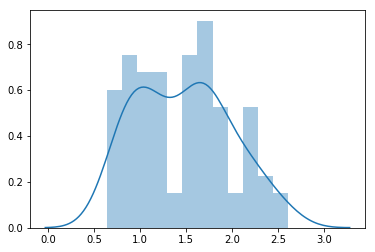

/h/spitis/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


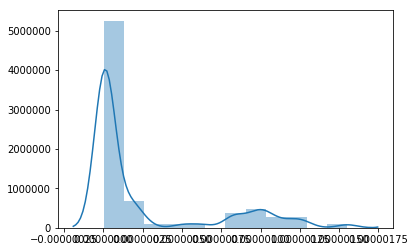

/h/spitis/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


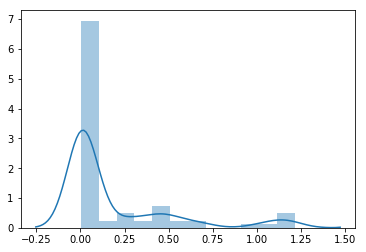

In [6]:
for c in model.components:
  m = c.mask.detach().cpu().numpy()
  sns.distplot(m.reshape(-1), bins=12)
  plt.show()